In [25]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

from umap.umap_ import UMAP

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [27]:
# 加载和预处理CIFAR10数据集
training_data = datasets.CIFAR10(root="./CIFAR10", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="./CIFAR10", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

Files already downloaded and verified
Files already downloaded and verified


In [28]:
# 计算数据方差用于损失归一化
data_variance = np.var(training_data.data / 255.0)

In [29]:
class VectorQuantizer(nn.Module):
    """基本的向量量化层"""
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        # 创建嵌入字典
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # 转换输入维度: BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # 展平输入
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # 计算输入向量与嵌入向量之间的距离
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # 获取最近邻的嵌入索引
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # 量化处理
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # 计算三种损失
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)  # 嵌入损失
        q_latent_loss = F.mse_loss(quantized, inputs.detach())  # 量化损失
        loss = q_latent_loss + self._commitment_cost * e_latent_loss  # 总损失
        
        # 直通估计器
        quantized = inputs + (quantized - inputs).detach()
        
        # 计算困惑度（代码书使用率指标）
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # 转换维度: BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [30]:
class VectorQuantizerEMA(nn.Module):
    """使用指数移动平均(EMA)的向量量化层"""
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        # EMA缓冲区
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # 维度转换 BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # 展平输入
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # 计算距离
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # 编码
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # 量化处理
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # EMA更新机制
        if self.training:
            # 更新聚类大小
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace平滑
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            # 更新嵌入权重
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # 损失计算 (只使用嵌入损失)
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # 直通估计器
        quantized = inputs + (quantized - inputs).detach()
        
        # 困惑度计算
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # 维度转换 BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [31]:
class Residual(nn.Module):
    """残差块模块"""
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)  # 残差连接

class ResidualStack(nn.Module):
    """残差堆栈模块"""
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        # 创建多个残差块
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [32]:
class Encoder(nn.Module):
    """编码器网络"""
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        # 卷积层序列
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        # 残差堆栈
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        x = self._conv_2(x)
        x = F.relu(x)
        x = self._conv_3(x)
        return self._residual_stack(x)  # 残差处理后的特征图

In [33]:
class Decoder(nn.Module):
    """解码器网络"""
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        # 转置卷积序列
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = self._residual_stack(x)
        x = self._conv_trans_1(x)
        x = F.relu(x)
        return self._conv_trans_2(x)  # 重建的RGB图像

In [34]:
# 超参数配置
batch_size = 128
num_training_updates = 15000  # 训练步数

num_hiddens = 128          # 主通道数
num_residual_hiddens = 32   # 残差块通道数
num_residual_layers = 2     # 残差块数量

embedding_dim = 256          # 嵌入向量维度
num_embeddings = 2048        # 嵌入向量数量（代码本大小）

commitment_cost = 0.25      # 嵌入损失权重
decay = 0.99                # EMA衰减率
learning_rate = 1e-3        # 学习率

In [35]:
# 创建数据加载器
training_loader = DataLoader(training_data, 
                             batch_size=batch_size, 
                             shuffle=True,
                             pin_memory=True)

In [36]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [37]:
class Model(nn.Module):
    """完整的VQ-VAE模型"""
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        # 根据设置选择量化器类型
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)  # 编码
        z = self._pre_vq_conv(z)  # 1x1卷积调整通道
        loss, quantized, perplexity, _ = self._vq_vae(z)  # 向量量化
        x_recon = self._decoder(quantized)  # 解码重建

        return loss, x_recon, perplexity

In [38]:
# 初始化模型
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [39]:
# 设置优化器
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [40]:
# 训练循环
model.train()
train_res_recon_error = []  # 重建误差记录
train_res_perplexity = []   # 困惑度记录

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    # 前向传播
    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance  # 归一化重建误差
    loss = recon_error + vq_loss  # 总损失
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()
    
    # 记录训练指标
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    # 定期输出训练状态
    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 4.894
perplexity: 1.050

200 iterations
recon_error: 0.992
perplexity: 1.000

300 iterations
recon_error: 0.985
perplexity: 1.000

400 iterations
recon_error: 0.985
perplexity: 1.000

500 iterations
recon_error: 0.761
perplexity: 1.537

600 iterations
recon_error: 0.538
perplexity: 1.900

700 iterations
recon_error: 0.717
perplexity: 2.301

800 iterations
recon_error: 0.464
perplexity: 4.156

900 iterations
recon_error: 0.360
perplexity: 7.812

1000 iterations
recon_error: 0.308
perplexity: 13.951

1100 iterations
recon_error: 0.278
perplexity: 19.019

1200 iterations
recon_error: 0.256
perplexity: 22.150

1300 iterations
recon_error: 0.245
perplexity: 24.468

1400 iterations
recon_error: 0.240
perplexity: 25.934

1500 iterations
recon_error: 0.232
perplexity: 27.053

1600 iterations
recon_error: 0.225
perplexity: 28.189

1700 iterations
recon_error: 0.223
perplexity: 29.610

1800 iterations
recon_error: 0.215
perplexity: 30.527

1900 iterations
recon_error:

## Plot Loss

In [41]:
# 平滑训练曲线
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

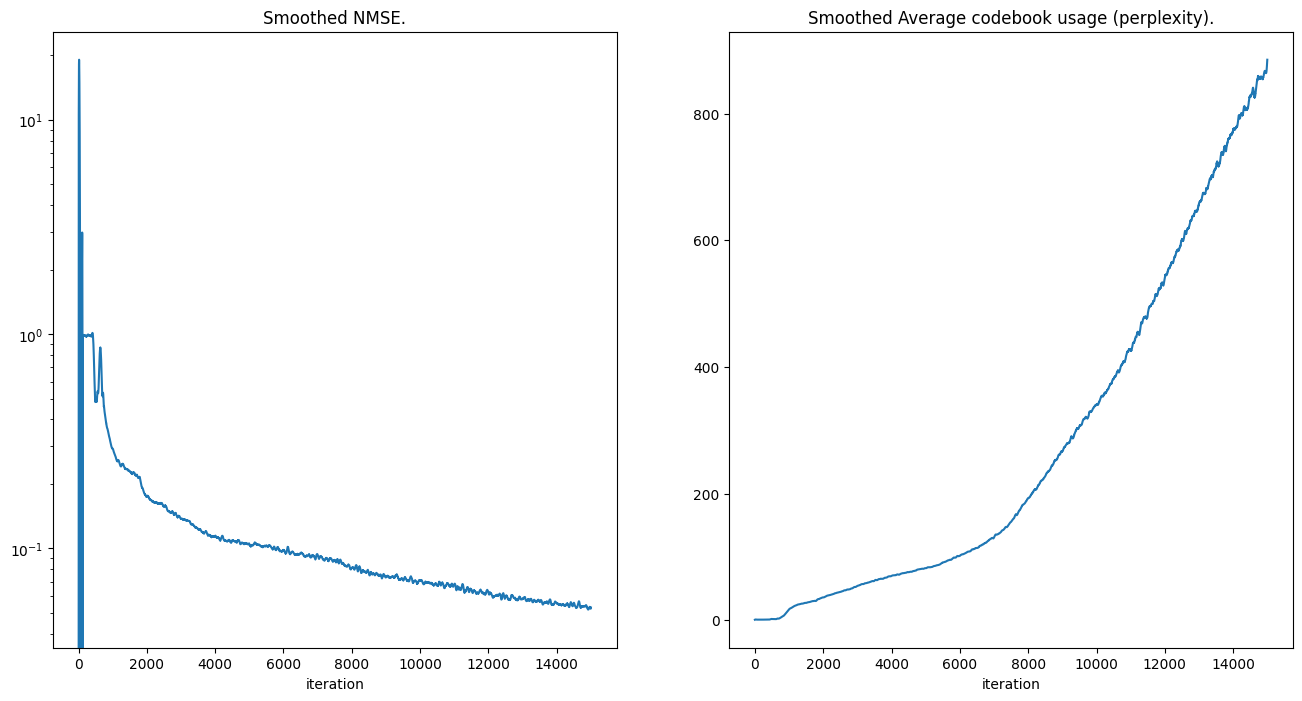

In [42]:
# 绘制训练曲线
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')


## View Reconstructions

In [43]:
# 评估模型
model.eval()

# 验证集重建
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [44]:
# 训练集重建
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [45]:
# 可视化辅助函数
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.122828364..1.1147926].


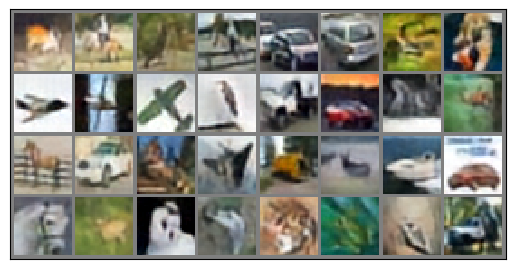

In [50]:
# 显示重建结果对比
show(make_grid(valid_reconstructions.cpu().data)+0.5)  # 重建图像

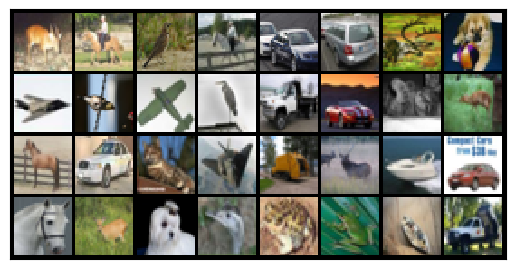

In [ ]:
show(make_grid(valid_originals.cpu()+0.5)) # 原始图像

## View Embedding

In [47]:
proj = UMAP(n_neighbors=3,
            min_dist=0.1,
            metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

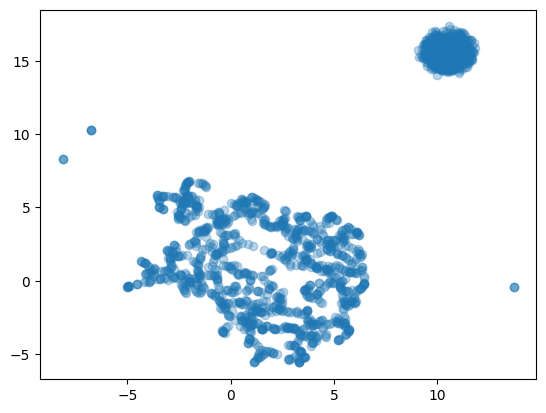

In [48]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)